In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sympy import symbols, Eq, solve
from datetime import datetime
from datetime import datetime
from dateutil.relativedelta import relativedelta


# Creating Dataframe

We are just builidng our original dataframe here with date, price, interest, and price changes

In [2]:
excel_file_path = 'chapt26.xlsx'
interest = pd.read_excel(excel_file_path, sheet_name='Data', usecols='A,H')
interest = interest.iloc[7:]
interest.columns = ['Year', 'Interest']
interest = interest.reset_index(drop=True)

In [3]:
excel_file_path = 'monthly_data.xls'
df = pd.read_excel(excel_file_path, sheet_name='Data', usecols='A,J')
df = df.iloc[7:]
df = df.reset_index(drop=True)
df.columns = ['Date', 'Price']

def correct_date_string_specific(date_str):
    parts = str(date_str).split('.')
    if len(parts) == 2 and parts[1] == '1':
        parts[1] = '10'
    return '.'.join(parts)

df['Date'] = df['Date'].apply(correct_date_string_specific)
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m')
df['Year'] = df['Date'].dt.year

In [4]:
df = pd.merge(interest, df, on = "Year")
df["Interest"] = (df["Interest"] - 1)/12
df = df[["Date", "Price", "Interest"]]

def add_percent_change (df):
    df = df.copy()
    diff = df['Price'].pct_change(fill_method=None)
    df["Percent Change"] = diff
    return df

df = add_percent_change(df)
df.head()

,Date,Price,Interest,Percent Change
0,1871-01-01,109.050018,0.003959,NaN
1,1871-02-01,107.765291,0.003959,-0.011781
2,1871-03-01,109.298845,0.003959,0.01423
3,1871-04-01,117.171191,0.003959,0.072026
4,1871-05-01,123.479273,0.003959,0.053836


# DataFrame Functions

In [5]:
def filter_dataframe_by_date (df, start_date=datetime(1500, 1, 1), end_date=datetime(9999, 1, 1)):
    
    filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    filtered_df.head()

    return filtered_df.reset_index(drop=True)

def compare_growth_of_diff_leverages (df, start_amount, contributions=5000):
    df.loc[0, "Total Normal Amount"] = start_amount
    df.loc[0, "Total 3x Leveraged Amount"] = start_amount
    df.loc[0, "Total 2.5x Leveraged Amount"] = start_amount
    df.loc[0, "Total 2x Leveraged Amount"] = start_amount
    for i in range(1, len(df)):
        percent_change = df.loc[i, "Percent Change"]
        interest_change  = df.loc[i, "Interest"]
        df.loc[i, 'Total Normal Amount'] = df.loc[i - 1, 'Total Normal Amount'] * (1 + percent_change) + contributions
        df.loc[i, 'Total 3x Leveraged Amount'] = df.loc[i - 1, 'Total 3x Leveraged Amount'] * (1 + ((3 * percent_change) - (2 * interest_change))) + contributions
        df.loc[i, 'Total 2.5x Leveraged Amount'] = df.loc[i - 1, 'Total 2.5x Leveraged Amount'] * (1 + ((2.5 * percent_change) - (1.5 * interest_change))) + contributions
        df.loc[i, 'Total 2x Leveraged Amount'] = df.loc[i - 1, 'Total 2x Leveraged Amount'] * (1 + ((2 * percent_change) - (1 * interest_change))) + contributions
    return df


# Math Functions

In [6]:

def market_drop(leveraged_x, new_leveraged_x):
    amount = 10000.
    leveraged_amount = amount * leveraged_x

    x = symbols('x')
    equation = Eq((leveraged_amount - x) / (amount - x), new_leveraged_x)
    total_amount_drop = solve(equation, x)[0]
    return total_amount_drop / amount


def calculate_diff_leverages_growth(df, month_interval=6, startamount=10000, contributions=5000):
    start_date = datetime(1871, 1, 1)
    end_date = datetime(1906, 1, 1)

    normal_end_amounts = []
    leveraged3x_end_amounts = []
    leveraged25x_end_amounts = []
    leveraged2x_end_amounts = []
    while end_date < datetime(2024, 1, 1):
        new_df = filter_dataframe_by_date(df, start_date, end_date)
        new_df = compare_growth_of_diff_leverages(new_df, startamount, contributions)

        normal_end_amount = new_df["Total Normal Amount"].iloc[-1]
        leveraged3x_end_amount = new_df["Total 3x Leveraged Amount"].iloc[-1]
        leveraged25x_end_amount = new_df["Total 2.5x Leveraged Amount"].iloc[-1]
        leveraged2x_end_amount = new_df["Total 2x Leveraged Amount"].iloc[-1]

        normal_end_amounts.append(normal_end_amount)
        leveraged3x_end_amounts.append(leveraged3x_end_amount)
        leveraged25x_end_amounts.append(leveraged25x_end_amount)
        leveraged2x_end_amounts.append(leveraged2x_end_amount)


        start_date += relativedelta(months=month_interval)
        end_date += relativedelta(months=month_interval)

    print(end_date)
    return normal_end_amounts, leveraged3x_end_amounts, leveraged25x_end_amounts, leveraged2x_end_amounts
    

In [ ]:
# price_diff = filter_dataframe_by_date(df, datetime(1871, 2, 1), datetime(1901, 2, 1))
# price_diff = compare_growth_of_diff_leverages(price_diff, 10000.)
# price_diff.tail()

In [ ]:
normal_list, leverage3x_list, leverage25x_list, leverage2x_list  = calculate_diff_leverages_growth(df, 6, 10000)

In [ ]:
s_normal = pd.Series(normal_list)
s_leverage3x = pd.Series(leverage3x_list)
s_leverage25x = pd.Series(leverage25x_list)
s_leverage2x = pd.Series(leverage2x_list)
print(s_normal.describe())
print(s_leverage3x.describe())

In [ ]:
# Plotting side-by-side boxplots
plt.figure(figsize=(8, 16))
plt.boxplot([s_normal, s_leverage3x, s_leverage25x, s_leverage2x], positions=[1, 2, 3, 4], showfliers=False)
plt.yscale('log')  # Using a logarithmic scale
plt.xticks([1, 2, 3, 4], ['Normal 1', '3x', '2.5x', '2x'])
plt.title('Comparison of Datasets')
plt.ylabel('Value (log scale)')
plt.show()

## List of Possible Glidepath Functions

In [23]:
def sigmoid_glide_path(amount):
    max_amount = 10000000
    steepness = 0.0000015
    # The logistic sigmoid function scaled to range from 1 to 3
    sigmoid = 1 / (1 + np.exp(-steepness * (amount - max_amount / 2)))
    return 5 - 4 * sigmoid

def linear_glide_path(amount, start_value=5, end_value=1, max_amount=10000000):
    if (amount > max_amount):
        return 1
    slope = (end_value - start_value) / max_amount
    return start_value + slope * amount

def other_glide_path (amount):
    amount = amount/1000000
    if amount < 2:
        return 5
    elif 2 <= amount <= 10:  # Adjusted curve to start from glide path of 5
        # Using a logarithmic curve for a smoother transition from 5
        return 5 - 4 * np.log10(1 + amount - 2) / np.log10(9)
    else:
        return 1
    
def other2_glide_path (amount):
    lev = 22000000/(amount+1)
    return max(1, min(5, lev-1.2))

def constant_leverage (amount, lev=5):
    return lev

## Graph of our Glide Path Function

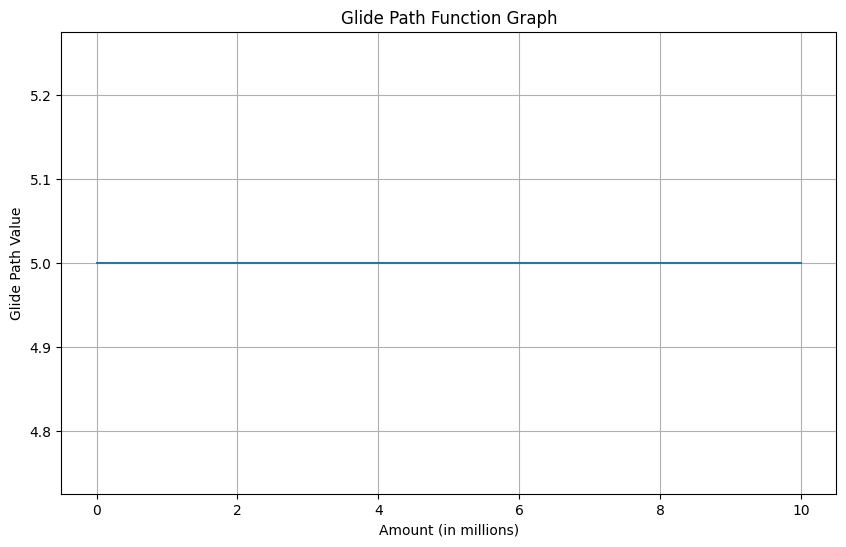

In [24]:
amounts = np.linspace(0, 10000000, 1000)  # From 0 to 8,000,000
glide_path_values = [constant_leverage(amount) for amount in amounts]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(amounts, glide_path_values, label='Glide Path')

scale_factor = 1e6
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_factor))
plt.gca().xaxis.set_major_formatter(ticks)
plt.title('Glide Path Function Graph')
plt.xlabel('Amount (in millions)')
plt.ylabel('Glide Path Value')
plt.grid(True)
plt.show()

In [38]:
def calculate_growth_with_glide_path (df, list_of_glide_path_func, start_amount=10000, contributions=5000,):
    df.loc[0, "Total Normal Amount"] = start_amount
    leverage_amount_str =  "Total Leveraged Amount "
    for i in range(0, len(list_of_glide_path_func)):
        t = leverage_amount_str + str(i)
        df.loc[0, t] = start_amount

    first_occur_arr = [0 for _ in range(len(list_of_glide_path_func))]
    happ = [False for _ in range(len(list_of_glide_path_func))]
    for i in range(1, len(df)):
        percent_change = df.loc[i, "Percent Change"]
        interest_change  = df.loc[i, "Interest"]
        df.loc[i, 'Total Normal Amount'] = df.loc[i - 1, 'Total Normal Amount'] * (1 + percent_change) + contributions


        for x, glide_path_func in enumerate(list_of_glide_path_func):
            t = leverage_amount_str + str(x)
            prev_amount = df.loc[i - 1, t]
            glide_path = glide_path_func(prev_amount)
            df.loc[i, t] = prev_amount * (1 + ((glide_path * percent_change) - ((glide_path - 1) * interest_change))) + contributions
            if (not happ[x] and df.loc[i, t] > 5000000):
                first_occur_arr[x] = i
                happ[x] = True

        
    return df, first_occur_arr

def calculate_all_amounts_with_glide_paths(df, list_of_glide_path_func, month_interval=6, startamount=10000., contributions=5000.):
    # 35 year time period
    start_date = datetime(1871, 1, 1)
    end_date = datetime(1906, 1, 1)

    array_of_amounts = []
    for _ in range(len(list_of_glide_path_func) + 1):
        array_of_amounts.append([])

    months_arr = []
    for _ in range(len(list_of_glide_path_func) ):
        months_arr.append([])

    while end_date < datetime(2024, 1, 1):
        new_df = filter_dataframe_by_date(df, start_date, end_date)
        new_df, index_of_months = calculate_growth_with_glide_path(new_df, list_of_glide_path_func, startamount, contributions)

        for i in range(0, len(list_of_glide_path_func) + 1):
            if (i == 0):
                normal_end_amount = new_df["Total Normal Amount"].iloc[-1]
                array_of_amounts[i].append(normal_end_amount)
            else :
                leverage_amount_str =  "Total Leveraged Amount "
                temp_str = leverage_amount_str + str(i - 1)
                array_of_amounts[i].append(new_df[temp_str].iloc[-1])

        for index, value in enumerate(index_of_months):
            months_arr[index].append(value)
    
        start_date += relativedelta(months=month_interval)
        end_date += relativedelta(months=month_interval)

    print(end_date)
    return months_arr, array_of_amounts

In [54]:
list_of_glide_path_func = [sigmoid_glide_path, linear_glide_path, other_glide_path, other2_glide_path]
months_list, leverage_list = calculate_all_amounts_with_glide_paths(df, list_of_glide_path_func)

2024-01-01 00:00:00


In [55]:
series_list = [pd.Series(inner_list) for inner_list in leverage_list]
# for list in series_list:
#     print(list.describe())

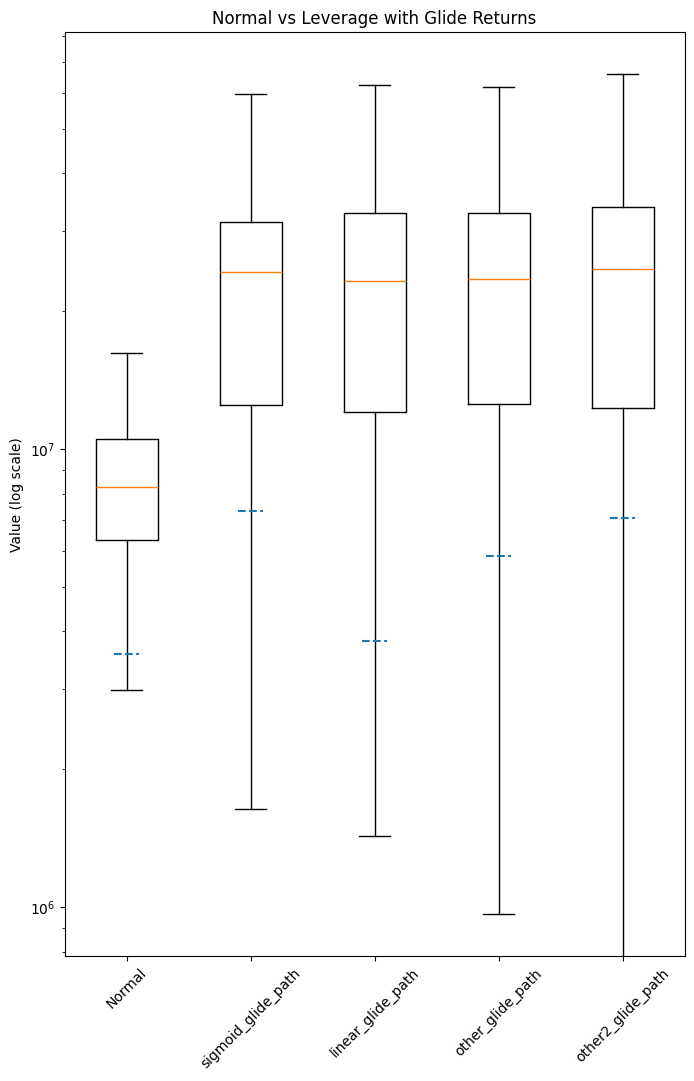

In [56]:
# Plotting side-by-side boxplots
plt.figure(figsize=(8, 12))
plt.boxplot(series_list, positions=[i for i in range(1,len(series_list) + 1)], showfliers=False)

# Calculate the xth percentile for each dataset
xth_perc = 2
for i, series in enumerate(series_list):
    percentile = np.percentile(series, xth_perc)
    plt.hlines(percentile, i + 0.9, i + 1.1, linestyles='dashed')


plt.yscale('log')  # Using a logarithmic scale
func_names = []
func_names.append
plt.xticks([i for i in range(1,len(series_list) + 1)], ["Normal"] + [func.__name__ for func in list_of_glide_path_func])
plt.xticks(rotation=45)
plt.title('Normal vs Leverage with Glide Returns')
plt.ylabel('Value (log scale)')
plt.show()

In [60]:
series_months_list = [pd.Series(inner_list) for inner_list in months_list]
# for list in series_months_list:
#     print(list.describe())

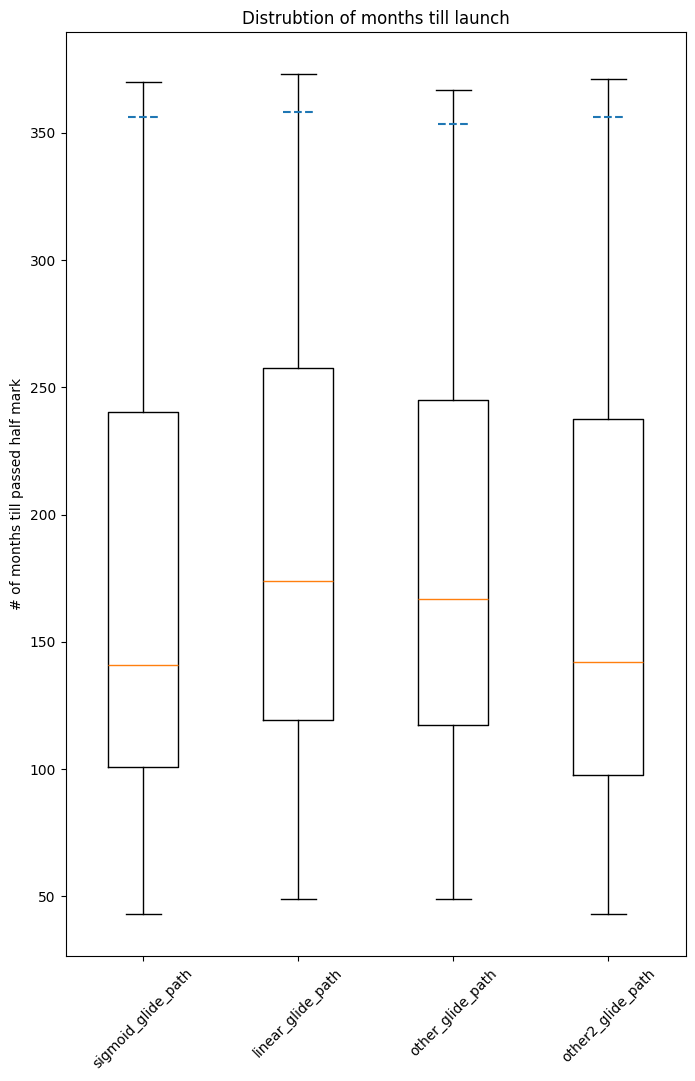

In [61]:
# plt.figure(figsize=(8, 12))
# plt.boxplot([series_months_list], positions=[1], showfliers=False)
# percentile_month = np.percentile(series_months_list, 90)
# plt.hlines(percentile_month, 0.9, 1.1, colors='blue', linestyles='dashed')
# plt.xticks([1], ['Months'])
# plt.title('Month Distribution')
# plt.ylabel('# of months')
# plt.show()


# Plotting side-by-side boxplots
plt.figure(figsize=(8, 12))
plt.boxplot(series_months_list, positions=[i for i in range(1,len(series_months_list) + 1)], showfliers=False)

# Calculate the xth percentile for each dataset
xth_perc = 98
for i, series in enumerate(series_months_list):
    percentile = np.percentile(series, xth_perc)
    plt.hlines(percentile, i + 0.9, i + 1.1, linestyles='dashed')

func_names = []
func_names.append
plt.xticks([i for i in range(1,len(series_months_list) + 1)], [func.__name__ for func in list_of_glide_path_func])
plt.xticks(rotation=45)
plt.title('Distrubtion of months till launch')
plt.ylabel('# of months till passed half mark')
plt.show()